In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [6]:
# Etiketler ve yolları tutacak listeler
label = []
path = []

# Dosya dizinini ayarlama
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'

# Klasör yapısını gezme ve verileri toplama
for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == '.png':  
            if 'GT' not in dir_name.split(os.sep):  
                label.append(os.path.split(dir_name)[-1]) 
                path.append(os.path.join(dir_name, filename))  

# DataFrame oluşturma
data = pd.DataFrame(columns=['path', 'label'])
data['path'] = path
data['label'] = label


data.head()


,path,label
0,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
1,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
2,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
3,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
4,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel


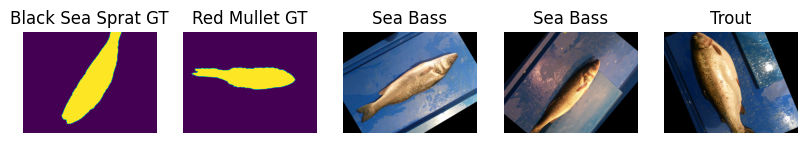

In [9]:
# Veri setinden rastgele 5 görüntüyü seçip görselleştirme
plt.figure(figsize=(10,10))
for i in range(5):
    img_path = random.choice(data['path'])  # Rastgele bir görüntü yolu seçme
    img = mpimg.imread(img_path)  # Görüntüyü yükleme
    label = data[data['path'] == img_path]['label'].values[0]  # Görüntünün etiketini alma
    
    # Görüntüyü çizme
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')  # Eksenleri kapatma

plt.show()


In [10]:
# Parametreler
img_size = (64, 64)

# Görüntüleri yükleme ve boyutlandırma
def load_images(paths):
    images = []
    for path in paths:
        img = load_img(path, target_size=img_size)
        img = img_to_array(img)
        images.append(img)
    return np.array(images)

# Görüntü ve etiketleri hazırlama
X = load_images(data['path'])
y = pd.get_dummies(data['label']).values

# Eğitim ve test seti olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verilerin boyutları
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")


X_train shape: (14400, 64, 64, 3), X_test shape: (3600, 64, 64, 3)


In [16]:
# Veri ön işleme
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255  # Normalizasyon
)

# Eğitim ve test verileri oluşturma
train_generator = datagen.flow(X_train, y_train, batch_size=32)
test_generator = datagen.flow(X_test, y_test, batch_size=32)


In [17]:
from tensorflow.keras.layers import BatchNormalization

# Modeli oluşturma
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))  # Çıkış katmanı


In [18]:
# Modeli derleme
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [19]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Modeli eğitme
history = model.fit(train_generator,
                    epochs=50,
                    validation_data=test_generator,
                    callbacks=[early_stopping, reduce_lr])


Epoch 1/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 85s 178ms/step - accuracy: 0.1817 - loss: 2.7510 - val_accuracy: 0.2322 - val_loss: 2.3167 - learning_rate: 1.0000e-04
Epoch 2/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 80s 177ms/step - accuracy: 0.3701 - loss: 1.7052 - val_accuracy: 0.4822 - val_loss: 1.2973 - learning_rate: 1.0000e-04
Epoch 3/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 81s 180ms/step - accuracy: 0.4255 - loss: 1.4726 - val_accuracy: 0.4908 - val_loss: 1.2605 - learning_rate: 1.0000e-04
Epoch 4/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 81s 178ms/step - accuracy: 0.4769 - loss: 1.3354 - val_accuracy: 0.5744 - val_loss: 1.0694 - learning_rate: 1.0000e-04
Epoch 5/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 81s 178ms/step - accuracy: 0.5111 - loss: 1.2348 - val_accuracy: 0.6003 - val_loss: 0.9902 - learning_rate: 1.0000e-04
Epoch 6/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 80s 177ms/step - accuracy: 0.5531 - loss: 1.1244 - val_accuracy: 0.5589 - val_loss: 1.0737 - learning_rate: 1.0000e-04
Epoch 7/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 81s 17

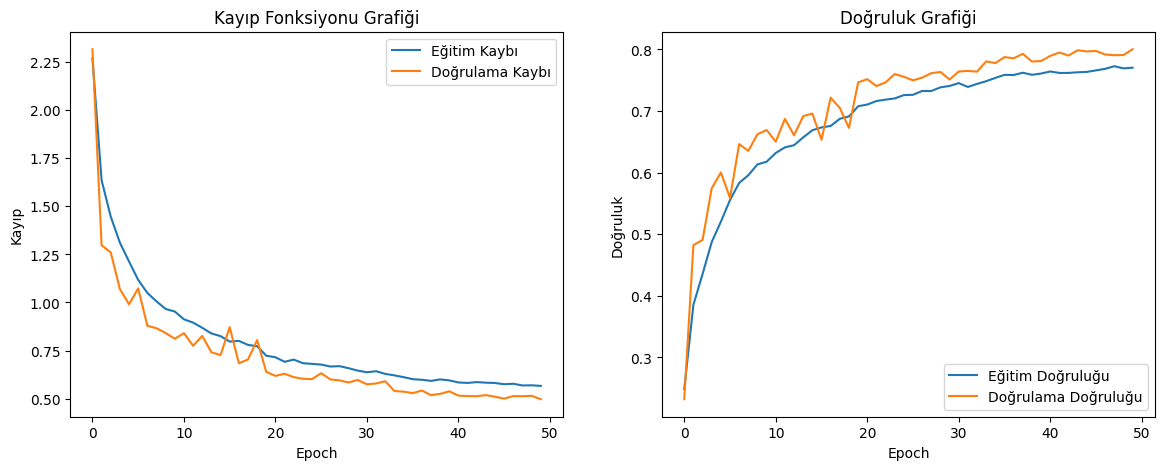

In [21]:
import matplotlib.pyplot as plt

# Eğitim kaybını ve doğruluğunu çizme
plt.figure(figsize=(14, 5))

# Kayıp fonksiyonu grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Kayıp Fonksiyonu Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

# Doğruluk grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Doğruluk Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

plt.show()


113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step


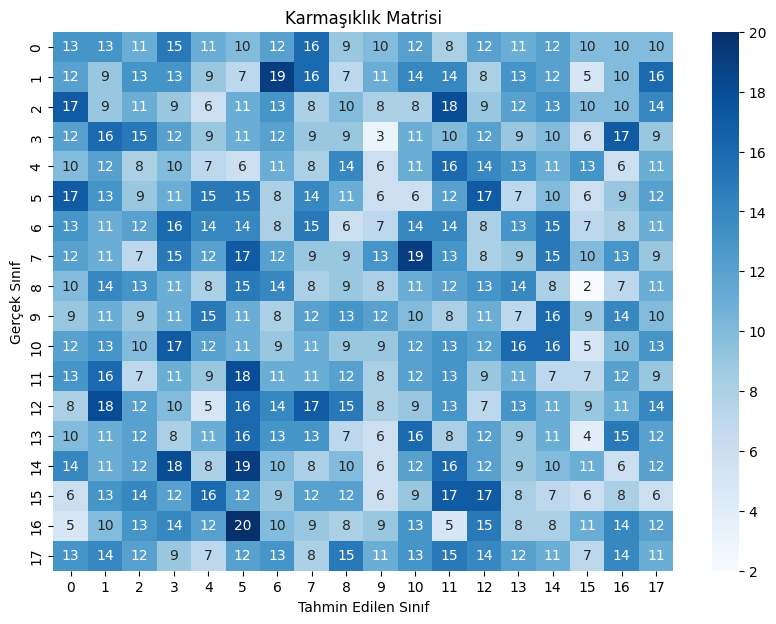

Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.06      0.06      0.06       205
           1       0.04      0.04      0.04       208
           2       0.06      0.06      0.06       196
           3       0.05      0.06      0.06       192
           4       0.04      0.04      0.04       187
           5       0.06      0.08      0.07       198
           6       0.04      0.04      0.04       206
           7       0.04      0.04      0.04       213
           8       0.05      0.05      0.05       188
           9       0.08      0.06      0.07       196
          10       0.06      0.06      0.06       210
          11       0.06      0.07      0.06       196
          12       0.03      0.03      0.03       210
          13       0.05      0.05      0.05       194
          14       0.05      0.05      0.05       204
          15       0.04      0.03      0.04       190
          16       0.07      0.07      0.07       196
    

In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Test verileri üzerinde tahmin yapma
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Karmaşıklık Matrisi
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Karmaşıklık Matrisi')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.show()

# Sınıflandırma Raporu
report = classification_report(y_true, y_pred_classes)
print("Sınıflandırma Raporu:\n", report)
